In [ ]:
import pandas as pd
import numpy as np
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Binary Experiment of DHL on untrained data

In [ ]:
Domain_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/untrained_domain_data.csv')
Domain_data.drop(["Unnamed: 0"], axis=1, inplace=True)
Domain_data.head()

,domain_name,label
0,s.w.org,legit
1,fonts.gstatic.com,legit
2,plus.google.com,legit
3,maps.google.com,legit
4,cdnjs.cloudflare.com,legit


In [ ]:
! pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.6 MB/s 


In [ ]:
def entropy(domain_name):
    """ Function which computes the entropy of a given domain name based on it's chars """
    elements, length = Counter(domain_name), len(domain_name)    
    
    return -sum(element/length * math.log(element/length, 2) for element in elements.values())

In [ ]:
import tldextract
def get_domain_name(domain):
    """ Function which extracts domain name from subdomain name """
    res = tldextract.extract(domain)
    return res.domain if len(res.domain) > len(res.subdomain) or entropy(res.domain) > entropy(res.subdomain) else res.subdomain

Domain_data["domain"] = Domain_data["domain_name"].apply(lambda domain: get_domain_name(domain))

In [ ]:
Domain_data.head()

,domain_name,label,domain
0,s.w.org,legit,s
1,fonts.gstatic.com,legit,gstatic
2,plus.google.com,legit,google
3,maps.google.com,legit,google
4,cdnjs.cloudflare.com,legit,cloudflare


In [ ]:
from sklearn.preprocessing import LabelEncoder
X = Domain_data.domain
Y = Domain_data['label']

In [ ]:
le=LabelEncoder()
Y = le.fit_transform(Y)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential

#max_words = num_words
max_len = 50

# Tokenizer
tok = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,padding='post',maxlen=max_len)

## import models and test

### CNN

In [ ]:
import pickle
filename = '/content/drive/My Drive/Colab Notebooks/BX_train_sm.csv'
X_train = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/By_train_sm.csv'
y_train = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/BX_test_sm.csv'
X_test = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/By_test_sm.csv'
y_test = pickle.load(open(filename, 'rb'))

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/Bcnnmodel2x32x3_2nd.sav'
loaded_cnn_model = pickle.load(open(filename, 'rb'))

In [ ]:
from tensorflow import keras
layer_name = 'flatten'
intermediate_layer_model = keras.Model(inputs=loaded_cnn_model.input,
                                 outputs=loaded_cnn_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(sequences_matrix)

#### CNN+XGB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+XGBmodel.sav'
BCNNXGBmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

ppred = BCNNXGBmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,ppred)
auc = metrics.roc_auc_score(Y,ppred)

In [ ]:
print(auc)

0.7643026721457709


In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
CNNXGBpred=BCNNXGBmodel.predict(intermediate_output)
print(classification_report(Y,CNNXGBpred))

              precision    recall  f1-score   support

           0       0.66      0.44      0.53    381671
           1       0.80      0.91      0.85    957416

    accuracy                           0.77   1339087
   macro avg       0.73      0.67      0.69   1339087
weighted avg       0.76      0.77      0.76   1339087



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


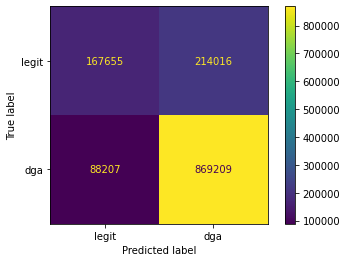

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(BCNNXGBmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNXGBpred,Y)
recall=recall_score(CNNXGBpred,Y)
f1=f1_score(CNNXGBpred,Y)
accuracy=accuracy_score(CNNXGBpred,Y)
print(precision,recall,f1,accuracy)

0.9078697243413522 0.8024270119319624 0.8518980065577434 0.774306673128781


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(BCNNXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(BCNNXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(BCNNXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)

In [ ]:
accuracy=accuracy_score(BCNNXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(accuracy,precision,recall,f1)

0.9724169812774481 0.9845199462418461 0.9262408832282238 0.9544916459437343


#### CNN+RF

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+RFmodel.sav'
CNNRFmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
CNNRFpred=CNNRFmodel.predict(intermediate_output)
print(classification_report(Y,CNNRFpred))

              precision    recall  f1-score   support

           0       0.65      0.37      0.47    381671
           1       0.79      0.92      0.85    957416

    accuracy                           0.76   1339087
   macro avg       0.72      0.64      0.66   1339087
weighted avg       0.75      0.76      0.74   1339087



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


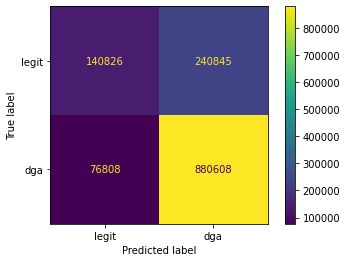

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(CNNRFmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNRFpred,Y)
recall=recall_score(CNNRFpred,Y)
f1=f1_score(CNNRFpred,Y)
accuracy=accuracy_score(CNNRFpred,Y)
print(precision,recall,f1,accuracy)

0.9197757296723681 0.7852384362073132 0.8471991260632584 0.7627838967893796


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(CNNRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(CNNRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(CNNRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(accuracy,precision,recall,f1)

0.9790984474921026 0.9904939849870521 0.9414202151274642 0.9653338231829308


#### CNN+NB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+NBmodel.sav'
CNNNBmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
CNNNBpred=CNNNBmodel.predict(intermediate_output)
print(classification_report(Y,CNNNBpred))

              precision    recall  f1-score   support

           0       0.42      0.57      0.48    381671
           1       0.80      0.69      0.74    957416

    accuracy                           0.65   1339087
   macro avg       0.61      0.63      0.61   1339087
weighted avg       0.69      0.65      0.66   1339087



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


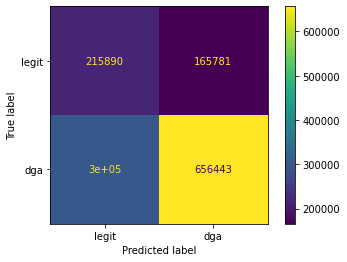

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(CNNNBmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNNBpred,Y)
recall=recall_score(CNNNBpred,Y)
f1=f1_score(CNNNBpred,Y)
accuracy=accuracy_score(CNNNBpred,Y)
print(precision,recall,f1,accuracy)

0.685640306825873 0.7983748954056316 0.7377256074262211 0.6514386294542476


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(CNNNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(CNNNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(CNNNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(accuracy,precision,recall,f1)

0.942917405038909 0.9019159537155407 0.9036191070460927 0.9027667270922707


#### CNN+LR

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+LRmodel.sav'
CNNLRmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

ppred = CNNLRmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,ppred)
auc = metrics.roc_auc_score(Y,ppred)

In [ ]:
print(auc)

0.7848327632484393


In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
CNNLRpred=CNNLRmodel.predict(intermediate_output)
print(classification_report(Y,CNNLRpred))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57    381671
           1       0.82      0.87      0.85    957416

    accuracy                           0.77   1339087
   macro avg       0.72      0.70      0.71   1339087
weighted avg       0.76      0.77      0.77   1339087



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


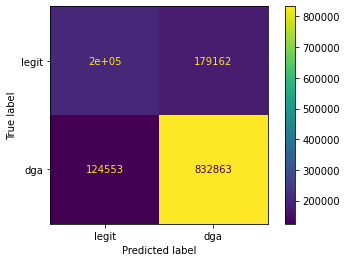

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(CNNLRmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNLRpred,Y)
recall=recall_score(CNNLRpred,Y)
f1=f1_score(CNNLRpred,Y)
accuracy=accuracy_score(CNNLRpred,Y)
print(precision,recall,f1,accuracy)

0.8699071250114893 0.8229668239420963 0.8457861900915031 0.7731924811457359


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(CNNLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(CNNLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(CNNLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(accuracy,precision,recall,f1)

0.9670381000077047 0.9784803487724129 0.9151962963530729 0.945780889842927


#### CNN+ET

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+ETmodel.sav'
CNNETmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
CNNETpred=CNNETmodel.predict(intermediate_output)
print(classification_report(Y,CNNETpred))

              precision    recall  f1-score   support

           0       0.65      0.37      0.47    381671
           1       0.79      0.92      0.85    957416

    accuracy                           0.76   1339087
   macro avg       0.72      0.65      0.66   1339087
weighted avg       0.75      0.76      0.74   1339087



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


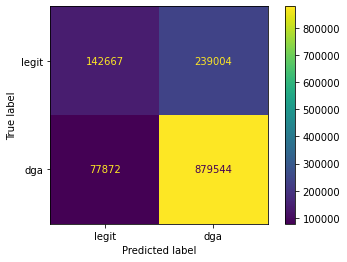

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(CNNETmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNETpred,Y)
recall=recall_score(CNNETpred,Y)
f1=f1_score(CNNETpred,Y)
accuracy=accuracy_score(CNNETpred,Y)
print(precision,recall,f1,accuracy)

0.9186644050235216 0.7863265590748005 0.8473595881238789 0.7633641428824266


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(CNNETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(CNNETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(CNNETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(accuracy,precision,recall,f1)

0.9780871985515063 0.9909447012161143 0.9379765589245961 0.9637333779642714


#### CNN+DT

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+DTmodel.sav'
CNNDTmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
CNNDTpred=CNNDTmodel.predict(intermediate_output)
print(classification_report(Y,CNNDTpred))

              precision    recall  f1-score   support

           0       0.53      0.40      0.45    381671
           1       0.78      0.86      0.82    957416

    accuracy                           0.73   1339087
   macro avg       0.66      0.63      0.64   1339087
weighted avg       0.71      0.73      0.72   1339087



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


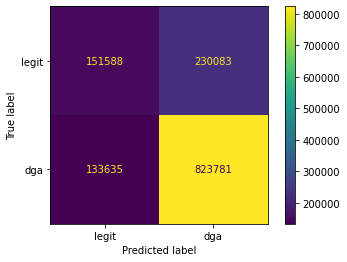

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(CNNDTmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNDTpred,Y)
recall=recall_score(CNNDTpred,Y)
f1=f1_score(CNNDTpred,Y)
accuracy=accuracy_score(CNNDTpred,Y)
print(precision,recall,f1,accuracy)

0.860421175330264 0.7816767628460598 0.8191609323415933 0.7283835927015945


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(CNNDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(CNNDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(CNNDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(accuracy,precision,recall,f1)

0.965333423222128 0.9649342773789622 0.9208637031939187 0.9423840317572111


#### CNN+AB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+ABmodel.sav'
CNNABmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
CNNABpred=CNNABmodel.predict(intermediate_output)
print(classification_report(Y,CNNABpred))

              precision    recall  f1-score   support

           0       0.63      0.54      0.58    381671
           1       0.83      0.88      0.85    957416

    accuracy                           0.78   1339087
   macro avg       0.73      0.71      0.72   1339087
weighted avg       0.77      0.78      0.77   1339087



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


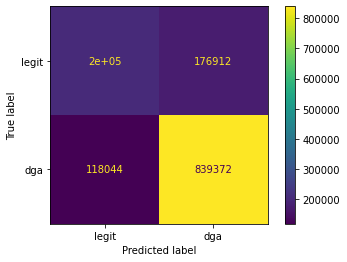

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(CNNABmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNABpred,Y)
recall=recall_score(CNNABpred,Y)
f1=f1_score(CNNABpred,Y)
accuracy=accuracy_score(CNNABpred,Y)
print(precision,recall,f1,accuracy)

0.8767056326612466 0.8259226751577315 0.8505568222120891 0.7797335049925808


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(CNNABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(CNNABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(CNNABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(CNNABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(accuracy,precision,recall,f1)

0.9685357115340165 0.9722686596518831 0.9245371236207219 0.9478023294828164


### LSTM

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/Blstmmodel32.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
from tensorflow import keras
layer_name = 'flatten_1'
intermediate_layer_model = keras.Model(inputs=loaded_model.input,
                                 outputs=loaded_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train)

#### LSTM+XGB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+XGBmodel.sav'
LSTMXGBmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMXGBpred=LSTMXGBmodel.predict(intermediate_output)
print(classification_report(Y,LSTMXGBpred))

              precision    recall  f1-score   support

           0       0.71      0.36      0.48    381671
           1       0.79      0.94      0.86    957416

    accuracy                           0.78   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.77      0.78      0.75   1339087



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
lxgbppred = LSTMXGBmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,lxgbppred)
auc = metrics.roc_auc_score(Y,lxgbppred)

In [ ]:
print(auc)

0.6417319364421444


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

#### LSTM+RF

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+RFmodel.sav'
LSTMRFmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMRFpred=LSTMRFmodel.predict(intermediate_output)
print(classification_report(Y,LSTMRFpred))

              precision    recall  f1-score   support

           0       0.72      0.35      0.47    381671
           1       0.79      0.95      0.86    957416

    accuracy                           0.78   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.77      0.78      0.75   1339087



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

lrfppred = LSTMRFmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,lrfppred)
auc = metrics.roc_auc_score(Y,lrfppred)

In [ ]:
print(auc)

0.624930141442295


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

#### LSTM+NB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+NBmodel.sav'
LSTMNBmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMNBpred=LSTMNBmodel.predict(intermediate_output)
print(classification_report(Y,LSTMNBpred))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60    381671
           1       0.83      0.89      0.86    957416

    accuracy                           0.79   1339087
   macro avg       0.75      0.72      0.73   1339087
weighted avg       0.79      0.79      0.79   1339087



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

lnbppred = LSTMNBmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,lnbppred)
auc = metrics.roc_auc_score(Y,lnbppred)

In [ ]:
print(auc)

0.8027170975451786


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

#### LSTM+LR

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+LRmodel.sav'
LSTMLRmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMLRpred=LSTMLRmodel.predict(intermediate_output)
print(classification_report(Y,LSTMLRpred))

              precision    recall  f1-score   support

           0       0.71      0.36      0.48    381671
           1       0.79      0.94      0.86    957416

    accuracy                           0.77   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.76      0.77      0.75   1339087



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

llrppred = LSTMLRmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,llrppred)
auc = metrics.roc_auc_score(Y,llrppred)

In [ ]:
print(auc)

0.6034633863905804


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

#### LSTM+ET

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+ETmodel.sav'
LSTMETmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMETpred=LSTMETmodel.predict(intermediate_output)
print(classification_report(Y,LSTMETpred))

              precision    recall  f1-score   support

           0       0.72      0.35      0.47    381671
           1       0.79      0.95      0.86    957416

    accuracy                           0.78   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.77      0.78      0.75   1339087



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

letppred = LSTMETmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,letppred)
auc = metrics.roc_auc_score(Y,letppred)

In [ ]:
print(auc)

0.6187121456671606


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

#### LSTM+DT

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+DTmodel.sav'
LSTMDTmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMDTpred=LSTMDTmodel.predict(intermediate_output)
print(classification_report(Y,LSTMDTpred))

              precision    recall  f1-score   support

           0       0.64      0.36      0.46    381671
           1       0.78      0.92      0.85    957416

    accuracy                           0.76   1339087
   macro avg       0.71      0.64      0.65   1339087
weighted avg       0.74      0.76      0.74   1339087



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

ldtppred = LSTMDTmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,ldtppred)
auc = metrics.roc_auc_score(Y,ldtppred)

In [ ]:
print(auc)

0.6392616292902034


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

#### LSTM+AB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+ABmodel.sav'
LSTMABmodel = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMABpred=LSTMABmodel.predict(intermediate_output)
print(classification_report(Y,LSTMABpred))

              precision    recall  f1-score   support

           0       0.72      0.36      0.48    381671
           1       0.79      0.94      0.86    957416

    accuracy                           0.78   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.77      0.78      0.75   1339087



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

labppred = LSTMABmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,labppred)
auc = metrics.roc_auc_score(Y,labppred)

In [ ]:
print(auc)

0.6116070536308327


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)